<a href="https://colab.research.google.com/github/DanielaOrovw/Intro-to-machine-learning/blob/master/Stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#We load the data
import pandas as pd
df=pd.read_csv('gdrive/My Drive/AMGN.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,INDPRO,UNRATE,CPIAUCSL,GDPC1,Inflation rate
2555,2/28/2019,191.380005,191.630005,189.729996,190.080002,190.080002,2776200,109.4447,3.8,253.113,18784.632,1.95
2556,3/1/2019,191.389999,192.059998,190.470001,191.160004,191.160004,2409400,109.4447,3.8,253.113,18784.632,1.96
2557,3/4/2019,191.820007,192.119995,187.410004,189.779999,189.779999,2274800,109.4447,3.8,253.113,18784.632,1.94
2558,3/5/2019,190.000000,190.669998,188.789993,188.820007,188.820007,3445200,109.4447,3.8,253.113,18784.632,1.93
2559,3/6/2019,188.880005,189.369995,182.429993,183.149994,183.149994,3956100,109.4447,3.8,253.113,18784.632,1.91


In [0]:
# import relevant modules
import pandas as pd
import numpy as np
import quandl, math
import datetime

# Machine Learning
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate as cross_validation
#Visualization
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Feature engineering

In [0]:
# define a new feature, HL_PCT
df['HL_PCT'] = (df['High'] - df['Low'])/(df['Low']*100)

# define a new feature percentage change
df['PCT_CHNG'] = (df['Adj Close'] - df['Open'])/(df['Open']*100)

#df = df[['Adj. Close', 'HL_PCT', 'PCT_CHNG', 'Adj. Volume']]

print(df.head())

       Date       Open       High        Low      Close  Adj Close    Volume  \
0  1/2/2009  58.590000  59.080002  57.750000  58.990002  49.414490   6547900   
1  1/5/2009  59.220001  59.650002  58.000000  59.650002  49.967358  10940100   
2  1/6/2009  60.040001  60.150002  57.750000  58.340000  48.870003   8974000   
3  1/7/2009  57.830002  58.750000  57.740002  58.200001  48.752728   5725400   
4  1/8/2009  58.060001  59.279999  58.020000  59.259998  49.640659   5576700   

    INDPRO  UNRATE  CPIAUCSL     GDPC1  Inflation rate    HL_PCT  PCT_CHNG  
0  91.0332     7.8   211.933  15155.94            0.17  0.000230 -0.001566  
1  91.0332     7.8   211.933  15155.94            0.15  0.000284 -0.001562  
2  91.0332     7.8   211.933  15155.94            0.42  0.000416 -0.001860  
3  91.0332     7.8   211.933  15155.94            0.47  0.000175 -0.001570  
4  91.0332     7.8   211.933  15155.94            0.50  0.000217 -0.001450  


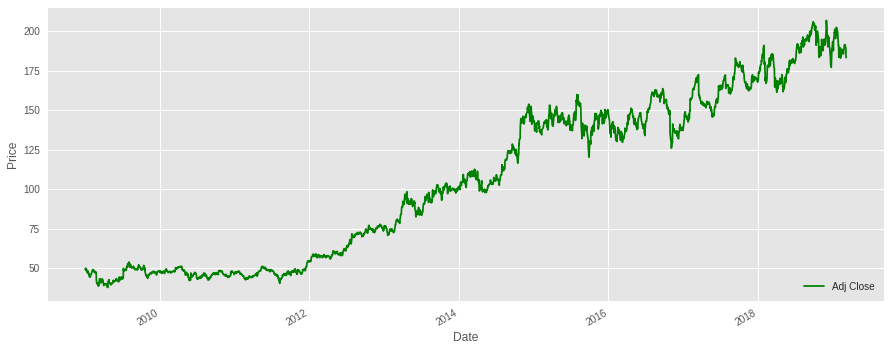

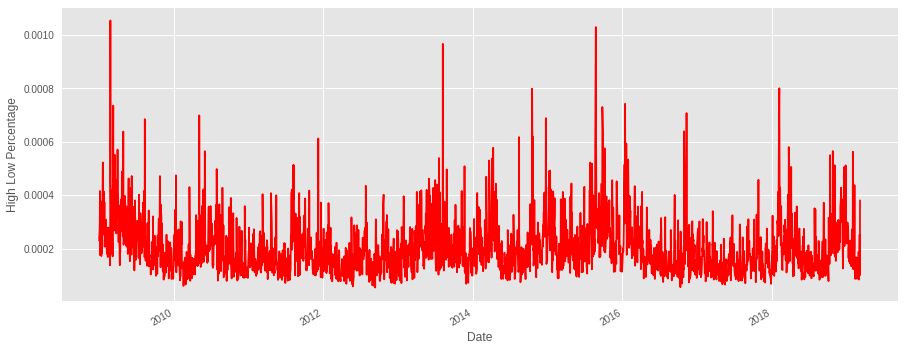

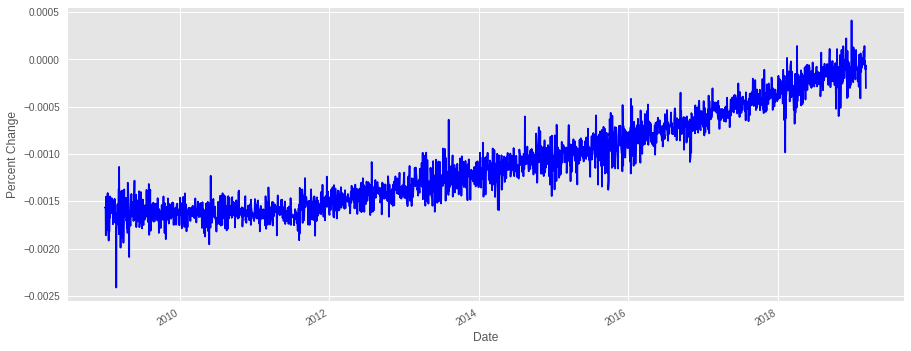

In [0]:
# Visualization
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y')
df.index = df['Date']

df['Adj Close'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

df['HL_PCT'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()

df['PCT_CHNG'].plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

Creating Features and Label

I want to forecast to year end hence I set forecast_out after next 214 days for my label (the entity that I want to predict). 

In [0]:
# pick a forecast column
forecast_col = 'Adj Close'

# Chosing 214 days as number of forecast days
forecast_out = int(214)
print('length =',len(df), "and forecast_out =", forecast_out)

length = 2560 and forecast_out = 214


In [0]:
# Creating label by shifting 'Adj Close' according to 'forecast_out'
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')
# If we look at the tail, it consists of n(=forecast_out) rows with NAN in Label column 
print(df.tail(2))

                 Date       Open       High    Low      Close  Adj Close  \
Date                                                                       
2009-01-02 2009-01-02  58.590000  59.080002  57.75  58.990002  49.414490   
2009-01-05 2009-01-05  59.220001  59.650002  58.00  59.650002  49.967358   

              Volume   INDPRO  UNRATE  CPIAUCSL     GDPC1  Inflation rate  \
Date                                                                        
2009-01-02   6547900  91.0332     7.8   211.933  15155.94            0.17   
2009-01-05  10940100  91.0332     7.8   211.933  15155.94            0.15   

              HL_PCT  PCT_CHNG      label  
Date                                       
2009-01-02  0.000230 -0.001566  45.812485  
2009-01-05  0.000284 -0.001562  45.996773  


                 Date        Open        High         Low       Close  \
Date                                                                    
2019-03-05 2019-03-05  190.000000  190.669998  188.789993  188

In [0]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,INDPRO,UNRATE,CPIAUCSL,GDPC1,Inflation rate,HL_PCT,PCT_CHNG,label
Date,,,,,,,,,,,,,,,
2009-01-02,2009-01-02,58.590000,59.080002,57.750000,58.990002,49.414490,6547900,91.0332,7.8,211.933,15155.940,0.17,0.000230,-0.001566,45.812485
2009-01-05,2009-01-05,59.220001,59.650002,58.000000,59.650002,49.967358,10940100,91.0332,7.8,211.933,15155.940,0.15,0.000284,-0.001562,45.996773
2009-01-06,2009-01-06,60.040001,60.150002,57.750000,58.340000,48.870003,8974000,91.0332,7.8,211.933,15155.940,0.42,0.000416,-0.001860,45.318249
2009-01-07,2009-01-07,57.830002,58.750000,57.740002,58.200001,48.752728,5725400,91.0332,7.8,211.933,15155.940,0.47,0.000175,-0.001570,45.887875
2009-01-08,2009-01-08,58.060001,59.279999,58.020000,59.259998,49.640659,5576700,91.0332,7.8,211.933,15155.940,0.50,0.000217,-0.001450,46.256451
2009-01-09,2009-01-09,59.099998,59.790001,57.619999,57.779999,48.400902,6150700,91.0332,7.8,211.933,15155.940,0.56,0.000377,-0.001810,46.415611
2009-01-12,2009-01-12,57.580002,57.720001,56.340000,57.060001,47.797779,7698300,91.0332,7.8,211.933,15155.940,0.59,0.000245,-0.001699,47.027111
2009-01-13,2009-01-13,57.160000,58.029999,57.049999,57.709999,48.342266,7466600,91.0332,7.8,211.933,15155.940,0.59,0.000172,-0.001543,47.144394
2009-01-14,2009-01-14,56.750000,57.259998,55.750000,56.080002,46.976849,6634600,91.0332,7.8,211.933,15155.940,0.45,0.000271,-0.001722,47.027111


In [0]:
df['Date'] = df['Date'].astype(int)
df.dtypes

Date                int64
Open              float64
High              float64
Low               float64
Close             float64
Adj Close         float64
Volume              int64
INDPRO            float64
UNRATE            float64
CPIAUCSL          float64
GDPC1             float64
Inflation rate    float64
HL_PCT            float64
PCT_CHNG          float64
label             float64
dtype: object

In [0]:
# Define features Matrix X by excluding the label column which we just created 
X = np.array(df.drop(['label'], 1))

# Using a feature in sklearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.72820533 -1.12329005 -1.12683812 -1.13585204 -1.11555282 -1.09415357
  1.9720519  -1.75512086  0.51433166 -1.91028494 -1.5391474  -5.40291097
  0.78882453 -0.93670116]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [0]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))



Length of X_forecast_out: 214 & Length of X : 2346


In [0]:
# Similarly Define Label vector y for the data we have prediction for
# A good test is to make sure length of X and y are identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

Length of y:  2346


Linear Regression 

We create training and test Sets using cross validation to shuffle the data and according to our test_size criteria, splits the data into test and training data.

In [0]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  1876 470


In [0]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.9740169841875707


Prediction

The Linear Regression model has an accuracy of 97% did fairly well on the test data set! Now I can go ahead and use this model to predict prices of shares for the next 30 days.

In [0]:
# Predict using our Model
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[198.05509467 198.71489351 197.72720751 198.7041522  195.78220751
 198.07836266 197.75387614 197.29176358 198.11286982 195.68748115
 196.91105293 199.87412572 199.04999647 200.30330379 201.78948978
 202.37238395 200.45160708 199.91649137 203.29543574 202.01398626
 201.16719714 199.8701771  202.39057242 198.71861405 200.19337426
 201.46673963 200.55904228 202.52535377 201.79442023 202.20513424
 202.09971239 203.09165313 200.75740601 203.18991798 202.51935868
 199.25786946 202.26919738 203.24281243 202.08972094 201.85170732
 203.08382768 202.27644906 201.61156394 201.15386842 200.4682029
 202.36141507 200.71842523 199.8123168  200.2486662  201.50678327
 204.10425988 203.61568972 202.14689926 203.9568036  201.22490191
 203.37183091 202.5853324  203.56997778 202.6926189  202.12404091
 201.54465377 203.77151238 204.3698396  203.24893208 196.2495893
 205.93280702 202.78571714 204.12497871 204.9134734  203.11922189
 207.18748327 206.17477668 203.74874643 204.32946914 205.62545013
 204.8202367

In [0]:
#make predictions and find the rmse
preds = clf.predict(X_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

7.812780632474813

The RMSE value is 7.8 which shows that linear regression has performed very well. Let’s look at the plot and understand why linear regression has not done well:

In [0]:
df=pd.read_csv('gdrive/My Drive/AMGN.csv',header=0, 
                  index_col='Date',
                  parse_dates=True)
df.tail()
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
df['Forecast'] = np.nan

In [0]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['Adj Close'].plot(figsize=(15,6), color="green")
df['forecast'].plot(figsize=(15,6), color="orange")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
forecast=pd.DataFrame(forecast_prediction)
forecast.tail()

,0
209,212.114205
210,211.577991
211,211.676124
212,211.560910
213,212.211540


Now, let’s run this data through prophet.

Prophet

There are a number of time series techniques that can be implemented on the stock prediction dataset, but most of these techniques require a lot of data preprocessing before fitting the model. Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large. Here is an interesting article that explains Prophet in a simple and intuitive manner:



In [0]:
#importing prophet
from fbprophet import Prophet
df=pd.read_csv('gdrive/My Drive/AMGN.csv')

In [0]:
#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Adj Close'][i] = df['Adj Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%m/%d/%Y')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Adj Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:1560]
valid = new_data[1560:]

#fit the model
model = Prophet()
model.fit(new_data)

#predictions
close_prices = model.make_future_dataframe(periods=365)
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['Adj Close'][i] = df['Adj Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%m/%d/%Y')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Adj Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:1560]
valid = new_data[1560:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
#rmse
forecast_valid = forecast['yhat'][1560:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

39.710180695791045

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


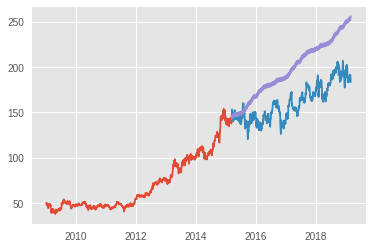

In [0]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

Inference Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time series datasets, but fails to live up to it’s reputation in this case.

As it turns out, stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA, SARIMA and Prophet would not show good results for this particular problem.


Long Short Term Memory (LSTM).

Long Short Term Memory (LSTM) Introduction LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

The input gate: The input gate adds information to the cell state The forget gate: It removes the information that is no longer required by the model The output gate: Output Gate at LSTM selects the information to be shown as output For a more detailed understanding of LSTM and its architecture, you can go through the below article:

In [0]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Adj Close'][i] = data['Adj Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1560,:]
valid = dataset[1560:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Epoch 1/1
 - 78s - loss: 6.5732e-04


In [0]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

4.545525268846728

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


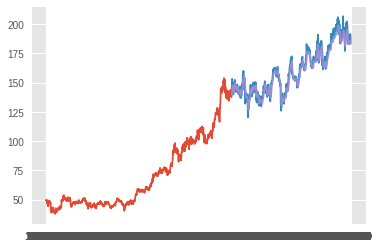

In [0]:
#for plotting
train = new_data[:1560]
valid = new_data[1560:]
valid['Predictions'] = closing_price
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])